# Gaussian Wave Packet Evolution in a 1D Anderson Chain — Video
Rafael Molina

This standalone notebook simulates the **time evolution of a Gaussian wave packet** in a **1D Anderson model** and produces an **MP4 video** using Matplotlib's animation tools.

**What you'll get:**
- A single-figure animation of the probability density $|\psi_n(t)|^2$ vs site index $n$.
- Overlaid text with time and mean-square displacement (MSD).
- An **MP4 file** saved to your Colab workspace and an in-notebook HTML preview.

> Run the cells top-to-bottom in Google Colab. If ffmpeg is not available for some reason, the notebook shows how to install it.

In [5]:
#@title Setup: imports (and optional ffmpeg install)
# If Colab lacks ffmpeg (usually it has it), uncomment the next line:
# !apt-get -y install ffmpeg

import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import scipy.linalg as la
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML, display

# Matplotlib defaults (no seaborn, no custom colors)
plt.rcParams.update({
    "figure.figsize": (7,4),
    "axes.grid": False,
})
print("Ready. NumPy:", np.__version__)

Ready. NumPy: 2.0.2


## Model and utilities

In [6]:
#@title Anderson model + evolution utilities
def uniform_disorder(N, W, rng=None):
    '''Uniform onsite disorder in [-W/2, W/2].'''
    if rng is None:
        rng = np.random.default_rng()
    return rng.uniform(-W/2, W/2, size=N)

def anderson_1d_hamiltonian(N, t=1.0, W=0.0, periodic=False, rng=None):
    '''1D tight-binding with onsite disorder (diagonal) and nearest-neighbor hopping t.'''
    eps = uniform_disorder(N, W, rng)
    diag = eps
    off = -t*np.ones(N-1, dtype=float)
    H = sp.diags([off, diag, off], offsets=[-1,0,1], format="csr")
    if periodic and N > 2:
        H = H.tolil()
        H[0, -1] = -t
        H[-1, 0] = -t
        H = H.tocsr()
    return H, eps

def gaussian_wavepacket(N, x0, sigma):
    x = np.arange(N, dtype=float)
    psi = np.exp(-0.5*((x - x0)/sigma)**2)
    psi = psi / la.norm(psi)
    return psi.astype(np.complex128)

def msd(psi):
    N = psi.size
    x = np.arange(N, dtype=float)
    prob = np.abs(psi)**2
    mean = np.sum(x*prob)
    return np.sum(((x-mean)**2)*prob)

def evolve_state_times(H, psi0, times):
    '''Return array of psi(t) for t in times using expm_multiply.'''
    if not sp.issparse(H):
        H = sp.csr_matrix(H)
    out = []
    for t in times:
        psi_t = spla.expm_multiply((-1j)*H, psi0, start=0.0, stop=t, num=2)[-1]
        out.append(psi_t)
    return np.array(out, dtype=np.complex128)

## Choose simulation parameters

In [15]:
#@title Parameters
N = 400        #@param {type:"integer"}
W = 0.01        #@param {type:"number"}
t_hop = 1.0    #@param {type:"number"}
periodic = False  #@param {type:"boolean"}

x0 = 200       #@param {type:"integer"}
sigma = 8.0    #@param {type:"number"}

t_max = 200.0   #@param {type:"number"}
n_frames = 120 #@param {type:"integer"}
fps = 24       #@param {type:"integer"}

rng_seed = 12345  #@param {type:"integer"}

# Derived
times = np.linspace(0.0, t_max, n_frames)
rng = np.random.default_rng(rng_seed)

print(f"Chain length N={N}, disorder W={W}, frames={n_frames}, t_max={t_max}, fps={fps}")

Chain length N=400, disorder W=0.01, frames=120, t_max=200.0, fps=24


## Build Hamiltonian and precompute evolution

In [16]:
#@title Precompute ψ(t) on the chosen time grid
H, eps = anderson_1d_hamiltonian(N, t=t_hop, W=W, periodic=periodic, rng=rng)
psi0 = gaussian_wavepacket(N, x0=x0, sigma=sigma)
psis = evolve_state_times(H, psi0, times)
msds = np.array([msd(psi) for psi in psis])

print("Precomputation complete. Example checks:")
print("norm(psi0) =", float(la.norm(psi0)))
print("MSD[0] =", float(msds[0]), "MSD[-1] =", float(msds[-1]))

Precomputation complete. Example checks:
norm(psi0) = 1.0
MSD[0] = 32.0 MSD[-1] = 1184.3367418185576


## Static preview (first and last frames)

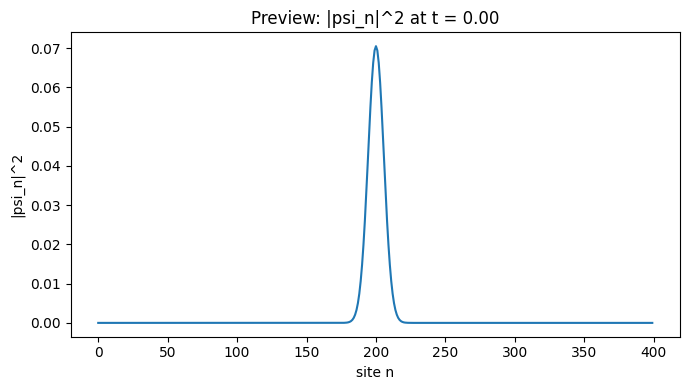

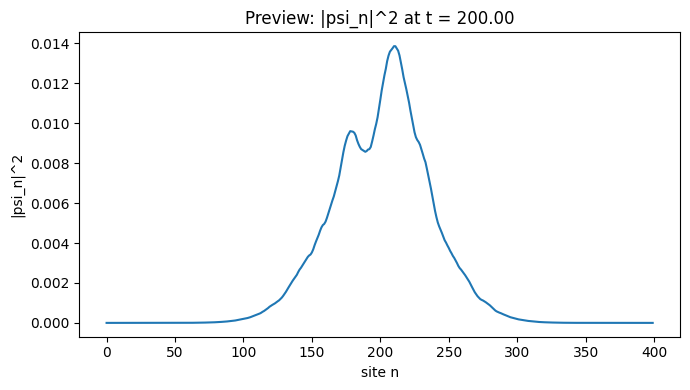

In [17]:
#@title Preview first and last frames
fig = plt.figure()
plt.title("Preview: |psi_n|^2 at t = {:.2f}".format(times[0]))
plt.xlabel("site n"); plt.ylabel("|psi_n|^2")
plt.plot(np.arange(N), np.abs(psis[0])**2)
plt.tight_layout()
plt.show()

fig = plt.figure()
plt.title("Preview: |psi_n|^2 at t = {:.2f}".format(times[-1]))
plt.xlabel("site n"); plt.ylabel("|psi_n|^2")
plt.plot(np.arange(N), np.abs(psis[-1])**2)
plt.tight_layout()
plt.show()

## Create and save the MP4 animation

In [18]:
#@title Make MP4 animation with Matplotlib + ffmpeg
save_path = "anderson_wavepacket.mp4"  # saved in current working directory (Colab: /content)

fig, ax = plt.subplots()
line, = ax.plot([], [])
text_time = ax.text(0.02, 0.95, "", transform=ax.transAxes, va="top")
ax.set_xlim(0, N-1)
ax.set_ylim(0, 1.05*np.max(np.abs(psis)**2))
ax.set_xlabel("site n")
ax.set_ylabel("|psi_n(t)|^2")
ax.set_title(f"Gaussian wave packet in a 1D Anderson chain with (W={W:.2f})")

x = np.arange(N)

def init():
    line.set_data([], [])
    text_time.set_text("")
    return line, text_time

def update(frame):
    y = np.abs(psis[frame])**2
    line.set_data(x, y)
    text_time.set_text(f"t = {times[frame]:.2f}   MSD = {msds[frame]:.2f}")
    return line, text_time

anim = FuncAnimation(fig, update, frames=n_frames, init_func=init, blit=True, interval=1000.0/fps)

# Save to MP4 with ffmpeg
try:
    writer = FFMpegWriter(fps=fps, bitrate=1800)
    anim.save(save_path, writer=writer)
    print(f"Saved video to {save_path}")
except Exception as e:
    print("FFmpeg writer failed. Error:", e)
    print("You can try installing ffmpeg by uncommenting the apt-get line in the setup cell.")

plt.close(fig)

# Inline HTML preview (if save succeeded)
try:
    display(HTML(anim.to_html5_video()))
except Exception as e:
    print("HTML5 inline video failed:", e)

Saved video to anderson_wavepacket.mp4


### Tips
- Increase `N`, `t_max`, and `n_frames` for higher-resolution videos (at higher compute cost).
- For weak disorder, the spread may look nearly ballistic before saturating (localization length can be large).
- For strong disorder, the packet quickly localizes and the MSD saturates early.
- To change the initial state, modify `x0` and `sigma`.